In [36]:
import os
from dotenv import load_dotenv


from langchain_openai import ChatOpenAI,embeddings
from langchain_ollama import OllamaEmbeddings, ChatOllama




In [ ]:
client = os.getenv("OPENAI_API_KEY")
client_source = os.getenv("TAVILY_API_KEY")
client_pinecone = os.getenv("PINECONE_API_KEY")
oembed = OllamaEmbeddings(base_url="http://localhost:11434", model="nomic-embed-text")
llm = ChatOpenAI(model="gpt-4o-mini")


In [38]:
from typing import Annotated, List, Tuple, Union, Literal
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random

python_repl_tool = PythonREPLTool()

# Tools


In [43]:
from pydantic import BaseModel
from typing import Annotated, List, Tuple, Union, Literal
from langgraph.prebuilt import ToolNode



@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
    """Retorna a entrada em minúsculas"""
    return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Retorna um número entre 0 e 100, mostrando a palavra 'random'"""
    return random.randint(0, 100)

tools = [to_lower_case, random_number_maker, python_repl_tool]

# testes
tool_node =ToolNode(tools)
model_with_tools=ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [ ]:
# teste
#model_with_tools.invoke("escreva DANIEL em minusculo?").tool_calls
tool_node.invoke({"messages": [model_with_tools.invoke("escreva DANIEL em minusculo?")]})

{'messages': [ToolMessage(content='daniel', name='lower_case', tool_call_id='call_wXo4FstWVZLoy39IyC77G2QY')]}

In [ ]:
# teste

from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END

# determina se um fluxo de continuar ou encerrar
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

#chama o modelo de linguagem (nó agente)
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

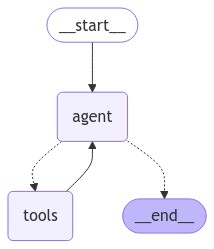

In [47]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
for chunk in app.stream(
    {"messages": [("human", "escreva DANIEL em minusculo")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

escreva DANIEL em minusculo
================================== Ai Message ==================================
Tool Calls:
  lower_case (call_IeNPCK2lCvlUhNL5fdtMqVFC)
 Call ID: call_IeNPCK2lCvlUhNL5fdtMqVFC
  Args:
    input: DANIEL
================================= Tool Message =================================
Name: lower_case

daniel
================================== Ai Message ==================================

daniel


# Helper Utils

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# Agente supervisor

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder



members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},

                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=list(options), members=", ".join(members))


supervisor_chain = (
    prompt
    #| llm.bind_tools(tools=[function_def],tool_choice="route")
    | llm.with_structured_output(routeResponse)
    | JsonOutputFunctionsParser()
)

# Agent and Graph State

In [ ]:
import operator
import functools
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    #next: str
    next: str[*options]

lotto_agent = create_agent(llm, tools, "You are a senior lotto manager. you run the lotto and get random numbers")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

code_agent = create_agent(llm, [python_repl_tool], "You may generate safe python code to analyze data and generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

# EDGES

In [ ]:
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.set_entry_point("supervisor")

graph = workflow.compile()

# grafico

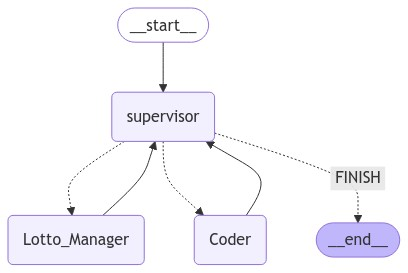

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# RUN

In [ ]:
config = {"recursion_limit": 20}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")

ValidationError: 1 validation error for Generation
text
  Input should be a valid string [type=string_type, input_value=routeResponse(next='Lotto_Manager'), input_type=routeResponse]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type